### Car Brand Classification

##### Import

In [1]:
all = [var for var in globals() if var[0] != "_"]   # globals() 목록의 첫글자가 _ 로 시작하지 않는 자료의 리스트만 가져와서
for var in all:
    del globals()[var]

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

##### Data load

In [3]:
PATH = 'd:/CarsDataset'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [4]:
# batchsize, image size 지정
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 3352 files belonging to 7 classes.
Found 813 files belonging to 7 classes.


In [5]:
class_names = train_dataset.class_names
class_names

['Audi',
 'Hyundai Creta',
 'Mahindra Scorpio',
 'Rolls Royce',
 'Swift',
 'Tata Safari',
 'Toyota Innova']

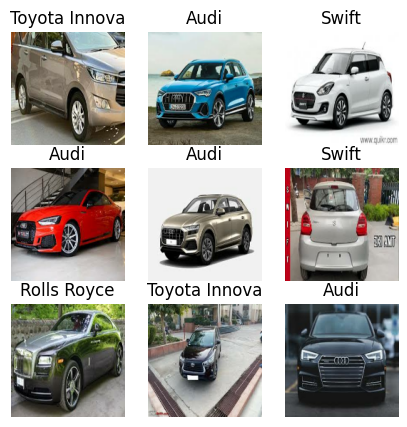

In [6]:
plt.figure(figsize=(5, 5))

for images, labels in train_dataset.take(1):
  for i in range(9):  # 9개의 이미지 출력
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))  # 이미지 표현을 위해 numpy 배열 dtype을 uint8로 지정
    plt.title(class_names[labels[i]])  # images에 해당하는 레이블 출력
    plt.axis("off") 

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

##### Data augmentation

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomContrast(0.3)
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


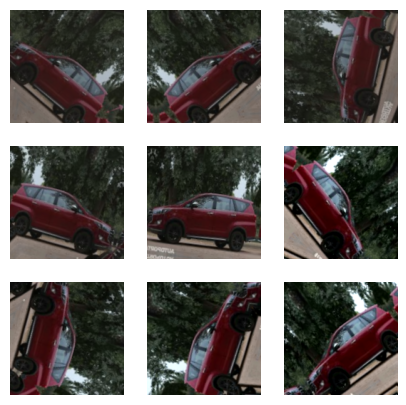

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(5,5))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    # tf.expand_dims를 통해 기존 이미지의 차원을 확장함 (first_image : 차원이 늘려질 배열, 0(axis) : 몇 번째 차원의 크기를 늘릴 것인지)
    # 차원 확장 후 이미지 증강 기법 적용
    # https://www.tensorflow.org/api_docs/python/tf/expand_dims
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

##### Transfer learning - MobileNetV2

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# rescaling과 같은 기능

In [11]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [12]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [13]:
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = tf.keras.layers.Dense(7, activation='softmax')

In [14]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)  # 데이터 증강
x = preprocess_input(x) # 전처리
x = base_model(x, training=False) # MobileNet V2d의 basemodel
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)  # output layer
model = tf.keras.Model(inputs, outputs)

##### Compile Model

In [15]:
base_learning_rate = 0.0001  # 학습률 지정
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [17]:
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


105/105 [==============================] - 8s 39ms/step - loss: 2.1841 - accuracy: 0.2079 - val_loss: 1.7700 - val_accuracy: 0.3592
Epoch 2/10
105/105 [==============================] - 3s 30ms/step - loss: 1.9616 - accuracy: 0.2736 - val_loss: 1.6165 - val_accuracy: 0.4231
Epoch 3/10
105/105 [==============================] - 3s 30ms/step - loss: 1.7745 - accuracy: 0.3446 - val_loss: 1.4963 - val_accuracy: 0.4809
Epoch 4/10
105/105 [==============================] - 3s 29ms/step - loss: 1.7047 - accuracy: 0.3640 - val_loss: 1.4042 - val_accuracy: 0.5154
Epoch 5/10
105/105 [==============================] - 3s 29ms/step - loss: 1.5718 - accuracy: 0.4135 - val_loss: 1.3311 - val_accuracy: 0.5437
Epoch 6/10
105/105 [==============================] - 3s 29ms/step - loss: 1.5180 - accuracy: 0.4412 - val_loss: 1.2627 - val_accuracy: 0.5744
Epoch 7/10
105/105 [==============================] - 3s 29ms/step - loss: 1.4591 - accuracy: 0.4633 - val_loss: 1.2005 - val_accuracy: 0.6027
Epoch 8/10

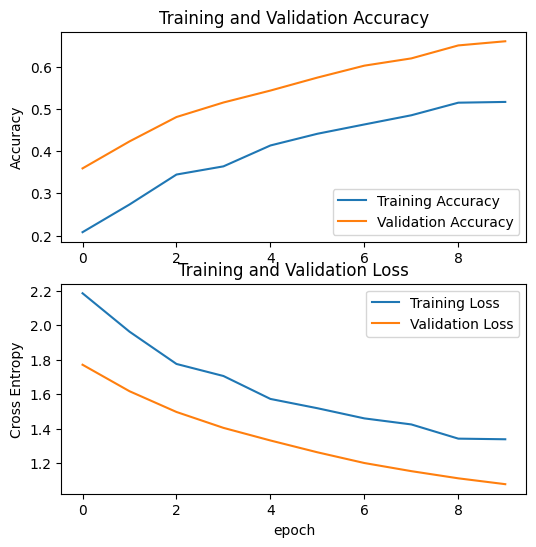

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##### Fine tuning

In [19]:
base_model.trainable = True

In [20]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [21]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [23]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


105/105 [==============================] - 8s 47ms/step - loss: 1.2438 - accuracy: 0.5519 - val_loss: 0.9236 - val_accuracy: 0.7183
Epoch 11/20
105/105 [==============================] - 4s 42ms/step - loss: 1.1075 - accuracy: 0.6020 - val_loss: 0.8086 - val_accuracy: 0.7380
Epoch 12/20
105/105 [==============================] - 4s 41ms/step - loss: 1.0159 - accuracy: 0.6408 - val_loss: 0.7446 - val_accuracy: 0.7552
Epoch 13/20
105/105 [==============================] - 4s 41ms/step - loss: 0.9302 - accuracy: 0.6730 - val_loss: 0.6412 - val_accuracy: 0.7897
Epoch 14/20
105/105 [==============================] - 4s 41ms/step - loss: 0.8568 - accuracy: 0.7082 - val_loss: 0.5980 - val_accuracy: 0.8130
Epoch 15/20
105/105 [==============================] - 4s 40ms/step - loss: 0.8194 - accuracy: 0.7214 - val_loss: 0.5581 - val_accuracy: 0.8303
Epoch 16/20
105/105 [==============================] - 4s 42ms/step - loss: 0.7678 - accuracy: 0.7372 - val_loss: 0.5287 - val_accuracy: 0.8364
Epoc

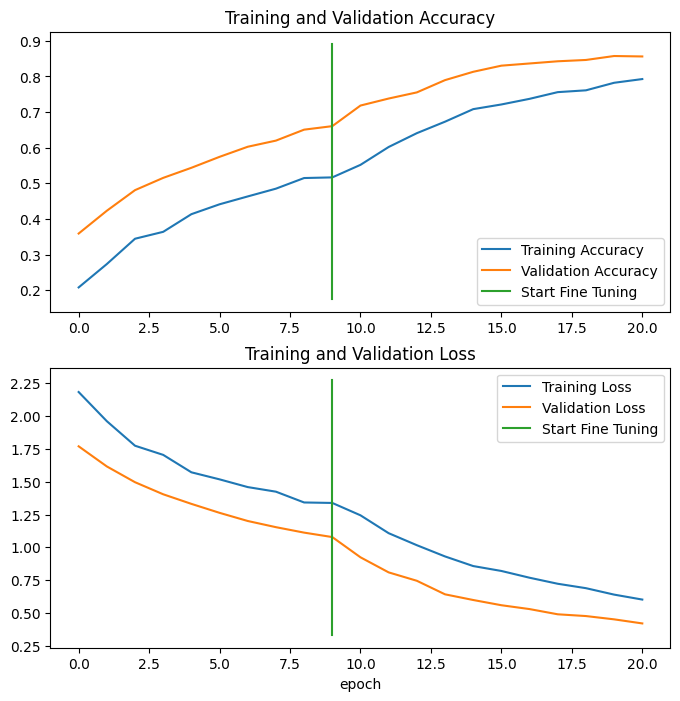

In [24]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##### Predict & Evaluation